# Simulation of Audio-Visual Duration Estimation with Causal Inference Model
This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls.
### Experimenter knows the true durations:
Standard duration($S_s$) is always 0.5s, test duration varies($S_t$).
We simulate and give the parameters to the model, and see how the estimates change.
Parameters:
- $\sigma_a$: Standard deviation of auditory measurement noise
- $\sigma_v$: Standard deviation of visual measurement noise
- $p_c$: Prior probability of common cause
### Parameters we dont need to adjust specifically:
- $c$: Conflict level between auditory and visual stimuli
- $\tmin$ and $\tmax$: Minimum and maximum test durations

### Steps:
1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5]
2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0]
3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms
4. For each combination of S_s, delta, and c:
    - Calculate test duration: S_t = S_s + delta + c
5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements.
6. Use the causal inference model to compute the final estimates based on the measurements and parameters.


In [1]:
# import lbraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, gaussian_kde
from ipywidgets import interact, FloatSlider, widgets
from scipy.special import expit  # Sigmoid function for probability mapping
import warnings


In [17]:
## Simulation of Audio-Visual Duration Estimation with Causal Inference Model This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls. ### Experimenter knows the true durations: Standard duration($S_s$) is always 0.5s, test duration varies($S_t$). We simulate and give the parameters to the model, and see how the estimates change. Parameters: - $\sigma_a$: Standard deviation of auditory measurement noise - $\sigma_v$: Standard deviation of visual measurement noise - $p_c$: Prior probability of common cause ### Parameters we dont need to adjust specifically: - $c$: Conflict level between auditory and visual stimuli - $\tmin$ and $\tmax$: Minimum and maximum test durations ### Steps: 1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5] 2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0] 3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms 4. For each combination of S_s, delta, and c: - Calculate test duration: S_t = S_s + delta + c 5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements. 6. Use the causal inference model to compute the final estimates based on the measurements and parameters.
# Standard durations of auditory stimuli
S_a_s = 0.5  # seconds
# repeat
S_a_s = np.repeat(S_a_s, 9940)
# Range of test durations (difference from standard) -100% to +100%
delta_percent = np.linspace(-1.0, 1.0, 7)  # -100% to +100%
# Convert percentage differences to absolute time differences (in seconds)
delta = delta_percent * S_a_s[0]  # since S_a_s is constant
# Constant conflict levels (in seconds)
c = np.array([-0.25, -0.167, -0.083, 0.0, 0.083, 0.167, 0.25])  # seconds
# Repeat each conflict level to match the number of standard durations
c = np.tile(c, int(len(S_a_s) / len(c)))
# Reshape delta to match the dimensions of S_a_s for broadcasting
delta = np.tile(delta, int(len(S_a_s) / len(delta)))

# Calculate test durations
S_a_t = S_a_s + delta 
S_v_s = S_a_s + c  # Visual test durations with conflict
S_v_t = S_a_t # no conflict in test durations for visual
# Combine standard and test durations, delta, and conflict into a single dataset
simData=np.column_stack((S_a_s, S_a_t, S_v_s, S_v_t, delta, c))
# Columns: [S_a_s, S_a_t, S_v_s, S_v_t, delta, c]

# create a dataframe
import pandas as pd
simData = pd.DataFrame(simData, columns=['S_a_s', 'S_a_t', 'S_v_s', 'S_v_t', 'delta', 'c'])





In [18]:
simData

,S_a_s,S_a_t,S_v_s,S_v_t,delta,c
0,0.5,0.000000,0.250,0.000000,-0.500000,-0.250
1,0.5,0.166667,0.333,0.166667,-0.333333,-0.167
2,0.5,0.333333,0.417,0.333333,-0.166667,-0.083
3,0.5,0.500000,0.500,0.500000,0.000000,0.000
4,0.5,0.666667,0.583,0.666667,0.166667,0.083
...,...,...,...,...,...,...
9935,0.5,0.333333,0.417,0.333333,-0.166667,-0.083
9936,0.5,0.500000,0.500,0.500000,0.000000,0.000
9937,0.5,0.666667,0.583,0.666667,0.166667,0.083
9938,0.5,0.833333,0.667,0.833333,0.333333,0.167


(9940,) (9940,)


ValueError: x and y must be the same size

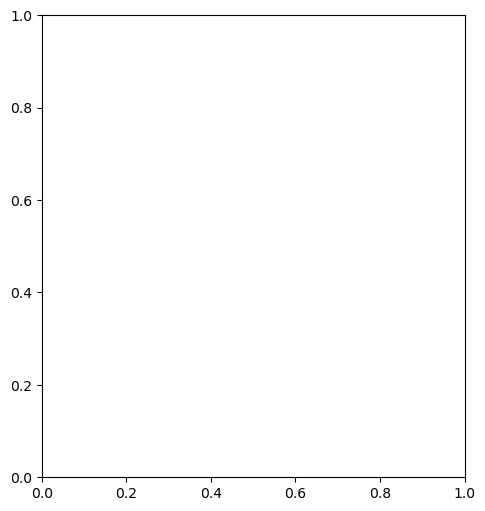

In [ ]:
# --- FUSION MODEL IMPLEMENTATION ---
def fusion_estimate(m_a, m_v, sigma_a, sigma_v):
    """Bayesian optimal integration of auditory and visual measurements."""
    # Calculate weights based on reliabilities (inverse variances)
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    # Compute the fused estimate
    fused_estimate = (w_a * m_a + w_v * m_v) /  w_a + w_v
    return fused_estimate
# --- CAUSAL INFERENCE MODEL IMPLEMENTATION ---
def p_single(m,sigma,t_min,t_max):
    """p(m | C=2)     and Gaussian measurement noise N(m; y, sigma^2). 
    and Gaussian measurement noise N(m; y, sigma^2)."""
    hi_cdf= norm.cdf((t_max - m) /sigma)
    lo_cdf=norm.cdf((t_min-m)/sigma)
    return (hi_cdf-lo_cdf)/(t_max-t_min)
# Causal inference model for duration estimation
def L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max-mu_c)/sigma_c)
    lo_cdf = norm.cdf((t_min-mu_c)/sigma_c)
    
    expo = np.exp(-(m_a-m_v)**2/(2*(sigma_a**2+sigma_v**2)))
    
    prior = 1/(t_max-t_min)
    return prior * sigma_c/np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf-lo_cdf) * expo

def L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    """ Likelihood of separate sources: product of two marginal likelihoods 
        two integral over two hidden duration y_a y_v"""
    return p_single(m_a,sigma_a,t_min,t_max) * p_single(m_v,sigma_v,t_min,t_max)

def posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max):
    """ Posterior probability of common cause P(C=1 | m_a,m_v) """
    # Likelihoods under each causal structure
    L1 = L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    L2 = L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    # Unnormalized posteriors
    post_C1_unnorm = L1 * p_c
    post_C2_unnorm = L2 * (1 - p_c)
    # Normalization constant
    norm_const = post_C1_unnorm + post_C2_unnorm
    # Posterior probabilities
    post_C1 = post_C1_unnorm / norm_const

    return post_C1

def estimate_duration(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max,lambda_=0.1, model="linear-space"):
    """ Final duration estimate as a weighted average of estimates under each causal structure """
    # Posterior probability of common cause
    p_C1 = posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max)
    
    # Estimate under common cause (fused estimate)
    est_C1 = fusion_estimate(m_a,m_v,sigma_a,sigma_v)
    # Estimate under separate causes (auditory estimate)
    est_C2 = m_a

    if model =="log-space":
        est_C1 = np.exp(est_C1)
        est_C2 = np.exp(est_C2)
    
    # Final estimate as a weighted average
    final_estimate = p_C1 * est_C1 + (1 - p_C1) * est_C2
    return final_estimate

# Calculate probablities of choosing test longer than standard
def prob_test_longer(est_standard,est_test, lambda_=0.1):
    """ Calculate the probability of choosing the test duration as longer than the standard duration. """
    p_base= np.mean(est_test > est_standard)
    p_final = (1-lambda_) * p_base + lambda_ * 0.5
    return p_final  

# Interactive simulation function
def simulate_duration_estimation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model="linear-space"):
    # Extract data
    S_a_s = simData['S_a_s'].values
    S_a_t = simData['S_a_t'].values
    S_v_s = simData['S_v_s'].values
    S_v_t = simData['S_v_t'].values
    delta = simData['delta'].values
    c = simData['c'].values
    
    # Measurement noise (for simplicity, we use true durations as measurements)
    m_a_s = S_a_s  # Auditory standard measurement
    m_a_t = S_a_t  # Auditory test measurement
    m_v_s = S_v_s  # Visual standard measurement
    m_v_t = S_v_t  # Visual test measurement
    
    # Time bounds for uniform prior on durations
    t_min = 0.1  # seconds
    t_max = 1.0  # seconds
    

    # Estimate durations using the causal inference model
    est_standard = estimate_duration(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, model)
    est_test = estimate_duration(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, model)
    
    # Calculate probability of choosing test as longer than standard
    p_test_longer = prob_test_longer(est_standard, est_test)
    
    # Plotting them as scatter projection (test duration vs p(choosing test longer)) like a psychometric function
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(delta*1000, p_test_longer, alpha=0.5)
    plt.title('Psychometric Function')
    plt.xlabel('Test Duration Difference from Standard (ms)')
    plt.ylabel('P(Choosing Test as Longer)')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlim(-250, 250)
    plt.subplot(1, 2, 2)
    estColor = 'orange' if model == "linear-space" else 'green'


simulate_duration_estimation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model="linear-space")

    
    